# üé• Cinematic Insights üçø

This notebook explores key factors contributing to the commercial success of movies by analyzing data from the OMDB API and a curated IMDb movie dataset from Kaggle. The objective is to identify actionable insights for the movie industry, focusing on genre popularity, audience trends, and runtime preferences.

### Goals:
1. **Genre Popularity**: Investigate whether genres with higher ratings and vote counts are more likely to succeed.
2. **Audience Trends**: Examine correlations between the popularity of actors and a movie's financial success.
3. **Runtime Preference**: Identify the optimal runtime range for maximizing commercial performance.

### Dataset:
The dataset combines information from the OMDB API and IMDB cleaned and structured to address the analysis goals. Cleaning steps included separating movies from TV shows, resolving formatting issues, handling duplicates, and removing irrelevant or incomplete records.

This notebook forms the analytical backbone of the project, providing the insights needed to accept or reject the defined hypotheses.


In [176]:
import pandas as pd
import requests
import time
import csv
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#Read data file
url = '/Users/mbouch17/Desktop/IronHack/Labs &  Project/cinematic-insights/csv_files/omdb_data.csv'
df = pd.read_csv(url)
df.head()

Title  \
0      Batteries not included   
1         10 Cloverfield Lane   
2  10 Things I Hate About You   
3                    10 Years   
4              10 to Midnight   

                                               Actor                    Genre  \
0  Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...  Comedy, Family, Fantasy   
1  John Goodman, Mary Elizabeth Winstead, John Ga...   Drama, Horror, Mystery   
2  Heath Ledger, Julia Stiles, Joseph Gordon-Levi...   Comedy, Drama, Romance   
3  Channing Tatum, Rosario Dawson, Chris Pratt, J...   Comedy, Drama, Romance   
4  Charles Bronson, Lisa Eilbacher, Andrew Steven...   Crime, Drama, Thriller   

   imdbRating imdbVotes  Runtime    BoxOffice  Year                    Awards  \
0         6.6    38,101      107  $32,945,797  1987     2 wins & 1 nomination   
1         7.2   361,826      103  $72,082,998  2016  16 wins & 48 nominations   
2         7.3   397,094       97  $38,178,166  1999   2 wins & 13 nominations   
3         6.1    27,291      100     $203,373  2011                       NaN   
4         6.3     9,596      101   $7,175,592  1983                       NaN   

         Country          Language   Type  
0  United States  English, Spanish  Movie  
1  United States           English  Movie  
2  United States   English, French  Movie  
3  United States           English  Movie  
4  United States           English  Movie

# Hypothesis 1: Genre Popularity
## '*Genres with higher average ratings and vote counts in the past 10 years will likely be more successful in terms of box office earnings*‚Äô

Correlation Matrix:
                avg_rating  avg_votes  avg_box_office
avg_rating        1.000000  -0.259565       -0.024418
avg_votes        -0.259565   1.000000        0.682402
avg_box_office   -0.024418   0.682402        1.000000


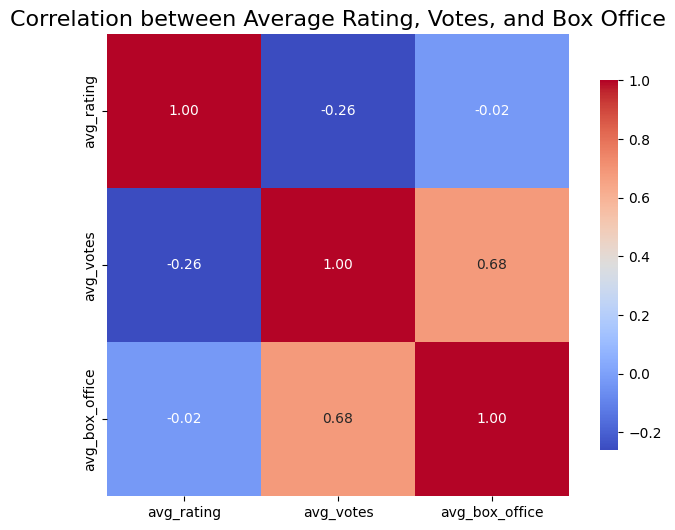

Top Genres by Average Box Office Earnings (Last 10 Years):
        Genre  avg_rating      avg_votes  avg_box_office
2   Animation    6.742105  137257.957895    1.397017e+08
1   Adventure    6.499600  266824.980000    1.327446e+08
8      Family    6.545455   59713.272727    6.007196e+07
0      Action    6.333971  151265.784689    4.677430e+07
15     Sci-Fi    6.198667  177581.866667    4.548199e+07
5       Crime    6.549153  138295.000000    3.391803e+07
16      Sport    6.647059   58058.352941    3.380538e+07
17   Thriller    6.150667  119624.555556    3.281226e+07
3   Biography    6.972368  106459.927632    3.133229e+07
11     Horror    5.893365   94012.867299    3.011555e+07


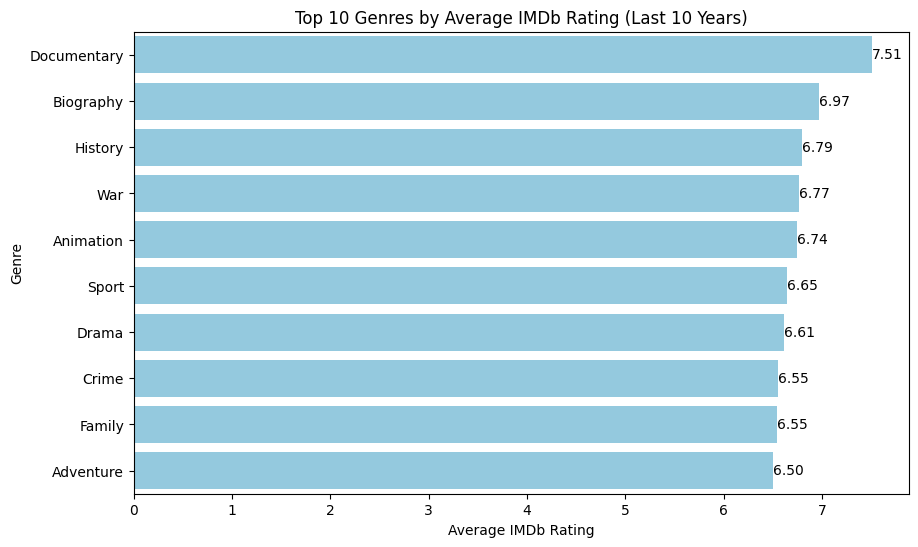

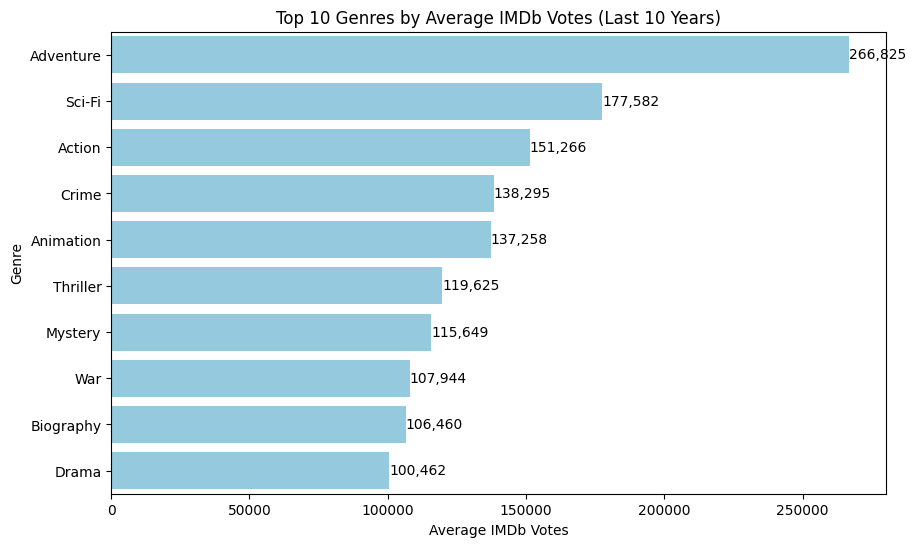

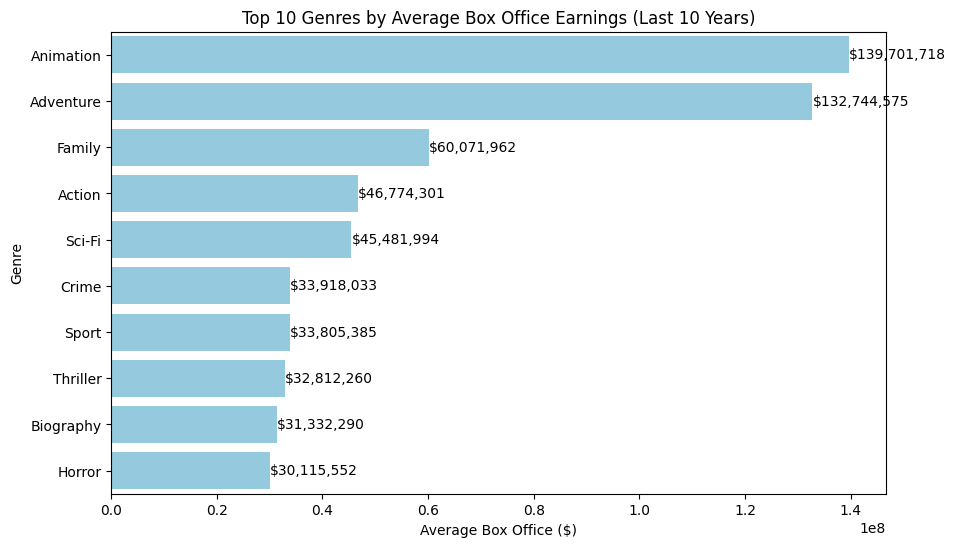

In [178]:
############################################# Hypothesis 1 ##########################################################

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
recent_years_df = df[df['Year'] >= (df['Year'].max() - 10)]

recent_years_df = recent_years_df.assign(Genre=recent_years_df['Genre'].str.split(',')).explode('Genre')
recent_years_df['Genre'] = recent_years_df['Genre'].str.strip()  

recent_years_df['BoxOffice'] = pd.to_numeric(recent_years_df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
recent_years_df['imdbVotes'] = pd.to_numeric(recent_years_df['imdbVotes'].replace(',', '', regex=True), errors='coerce')

# Calculate average metrics
genre_statistics_recent_df = recent_years_df.groupby('Genre').agg(
    avg_rating=('imdbRating', 'mean'),      
    avg_votes=('imdbVotes', 'mean'),        
    avg_box_office=('BoxOffice', 'mean')
).reset_index()

# Correlation between Rating, Votes, and Box Office
correlation_matrix = genre_statistics_recent_df[['avg_rating', 'avg_votes', 'avg_box_office']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation between Average Rating, Votes, and Box Office', fontsize=16)
plt.show()

# Sort genres by average box office earnings (already done)
genre_sorted_by_box_office = genre_statistics_recent_df.sort_values(by='avg_box_office', ascending=False).head(10)
print("Top Genres by Average Box Office Earnings (Last 10 Years):")
print(genre_sorted_by_box_office)

# Sort genres by average rating (descending)
genre_sorted_by_rating = genre_statistics_recent_df.sort_values(by='avg_rating', ascending=False).head(10)

# Sort genres by average votes (descending)
genre_sorted_by_votes = genre_statistics_recent_df.sort_values(by='avg_votes', ascending=False).head(10)

# Bar chart for average rating by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='Genre', data=genre_sorted_by_rating, color='skyblue')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average IMDb Rating (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_rating['avg_rating']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

# Bar chart for average votes by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_votes', y='Genre', data=genre_sorted_by_votes, color='skyblue')
plt.xlabel('Average IMDb Votes')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average IMDb Votes (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_votes['avg_votes']):
    plt.text(value, index, f'{value:,.0f}', va='center')  # Adding comma to votes
plt.show()

# Bar chart for average box office earnings by Genre
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_box_office', y='Genre', data=genre_sorted_by_box_office, color='skyblue')
plt.xlabel('Average Box Office ($)')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average Box Office Earnings (Last 10 Years)')
for index, value in enumerate(genre_sorted_by_box_office['avg_box_office']):
    plt.text(value, index, f'${value:,.0f}', va='center')  # Adding comma to box office earnings
plt.show()




Movies with High Box Office and Low Votes:
                         Title      Genre  BoxOffice  imdbVotes
789   Clifford the Big Red Dog  Adventure   48947356      17455
1725        I Can Only Imagine  Biography   83482352      18732
1870          Jesus Revolution      Drama   52102987      14613
3484       The Addams Family 2  Animation   56489153      15848
3788        The Garfield Movie  Animation   91956547      16867
4526      Trolls Band Together  Animation  102996915      16305
Movies with Low Box Office and High Ratings:
                                 Title        Genre  BoxOffice  imdbRating
213   All the Beauty and the Bloodshed  Documentary     500082         7.5
247                     American Honey    Adventure     663246         7.0
288                          Andhadhun        Crime    1193046         8.2
288                          Andhadhun      Mystery    1193046         8.2
288                          Andhadhun     Thriller    1193046         8.2
...           

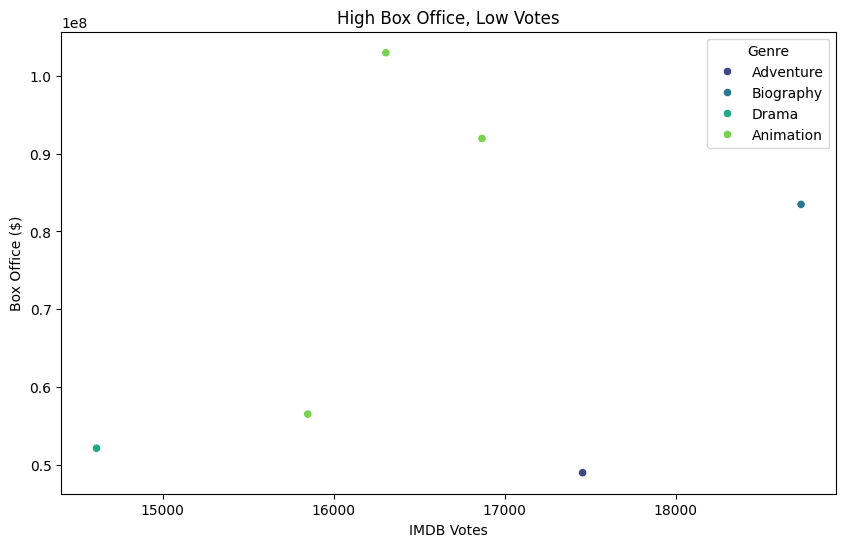

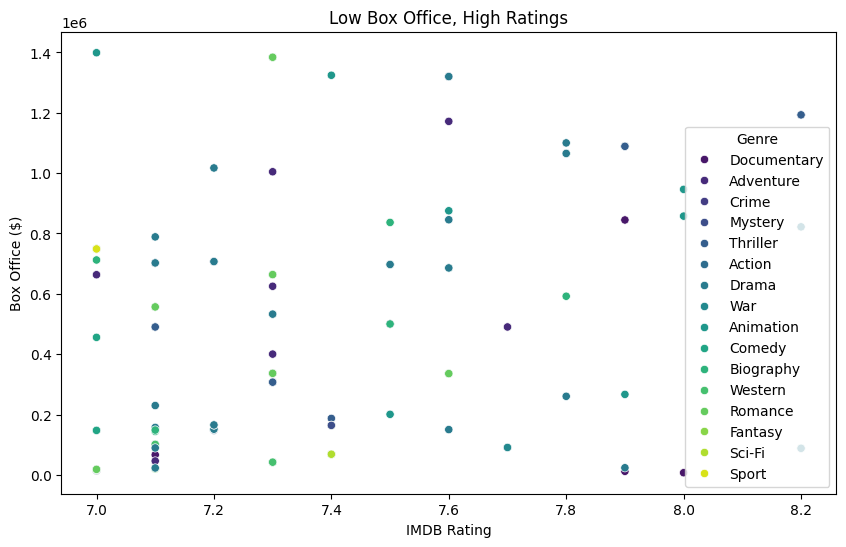

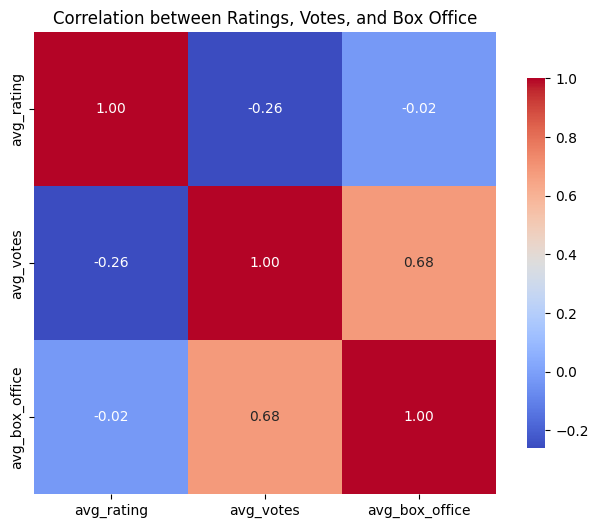

In [179]:
# Further Analysis

# Define thresholds
high_box_office_threshold = recent_years_df['BoxOffice'].quantile(0.75)  # Top 25% Box Office
low_votes_threshold = recent_years_df['imdbVotes'].quantile(0.25)        # Bottom 25% Votes
low_box_office_threshold = recent_years_df['BoxOffice'].quantile(0.25)  # Bottom 25% Box Office
high_ratings_threshold = recent_years_df['imdbRating'].quantile(0.75)   # Top 25% Ratings

# High Box Office, Low Votes
high_box_office_low_votes = recent_years_df[
    (recent_years_df['BoxOffice'] >= high_box_office_threshold) & 
    (recent_years_df['imdbVotes'] <= low_votes_threshold)
]
print("Movies with High Box Office and Low Votes:")
print(high_box_office_low_votes[['Title', 'Genre', 'BoxOffice', 'imdbVotes']])

# Low Box Office, High Ratings
low_box_office_high_ratings = recent_years_df[
    (recent_years_df['BoxOffice'] <= low_box_office_threshold) & 
    (recent_years_df['imdbRating'] >= high_ratings_threshold)
]
print("Movies with Low Box Office and High Ratings:")
print(low_box_office_high_ratings[['Title', 'Genre', 'BoxOffice', 'imdbRating']])

# Negative Correlations with Ratings
negative_correlation = genre_statistics_recent_df[genre_statistics_recent_df['avg_box_office'] < 0]
print("Genres with Negative Correlation between Ratings and Box Office:")
print(negative_correlation)

# Visualizations

# 1. Scatter plot for High Box Office, Low Votes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=high_box_office_low_votes,
    x='imdbVotes',
    y='BoxOffice',
    hue='Genre',
    palette='viridis'
)
plt.title('High Box Office, Low Votes')
plt.xlabel('IMDB Votes')
plt.ylabel('Box Office ($)')
plt.legend(title='Genre')
plt.show()

# 2. Scatter plot for Low Box Office, High Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=low_box_office_high_ratings,
    x='imdbRating',
    y='BoxOffice',
    hue='Genre',
    palette='viridis'
)
plt.title('Low Box Office, High Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Box Office ($)')
plt.legend(title='Genre')
plt.show()

# 3. Heatmap for Negative Correlations
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation between Ratings, Votes, and Box Office')
plt.show()


# Hypothesis 2: Audience Trends 
## '*There is a correlation between a movie's financial success and the popularity of its featured actors*‚Äô

Correlation Matrix between Actor Popularity and Box Office:
                       normalized_rating  normalized_votes  \
normalized_rating               1.000000          0.158251   
normalized_votes                0.158251          1.000000   
normalized_box_office           0.101481          0.872208   

                       normalized_box_office  
normalized_rating                   0.101481  
normalized_votes                    0.872208  
normalized_box_office               1.000000  


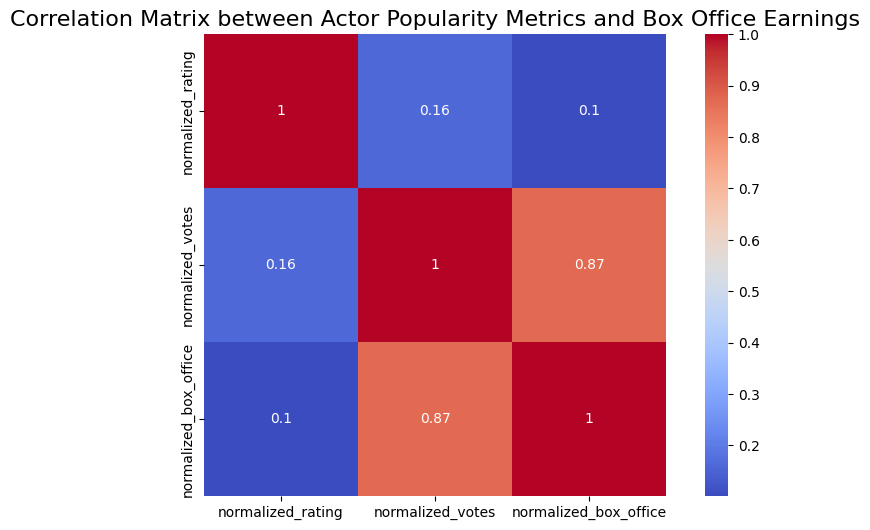

             Lead_Actor  num_movies  avg_rating  total_votes  \
1948          Tom Hanks          32    7.162500     12876434   
1943         Tom Cruise          31    7.035484     10479956   
1214  Leonardo DiCaprio          18    7.561111     13910954   
357      Christian Bale          20    7.265000     11985178   
226           Brad Pitt          19    7.268421     10061632   
...                 ...         ...         ...          ...   
1056      Julia Sweeney           1    2.800000        10548   
134      Anthony Newley           1    2.700000         8818   
665         Gary Graham           1    2.500000        15136   
32          Albie Hecht           1    2.400000          243   
1522       Paris Hilton           1    2.000000        39184   

      total_box_office  normalized_rating  normalized_votes  \
1948        4120929291           0.770522          0.925632   
1943        4087880697           0.751565          0.753358   
1214        2329220035           0.830017 

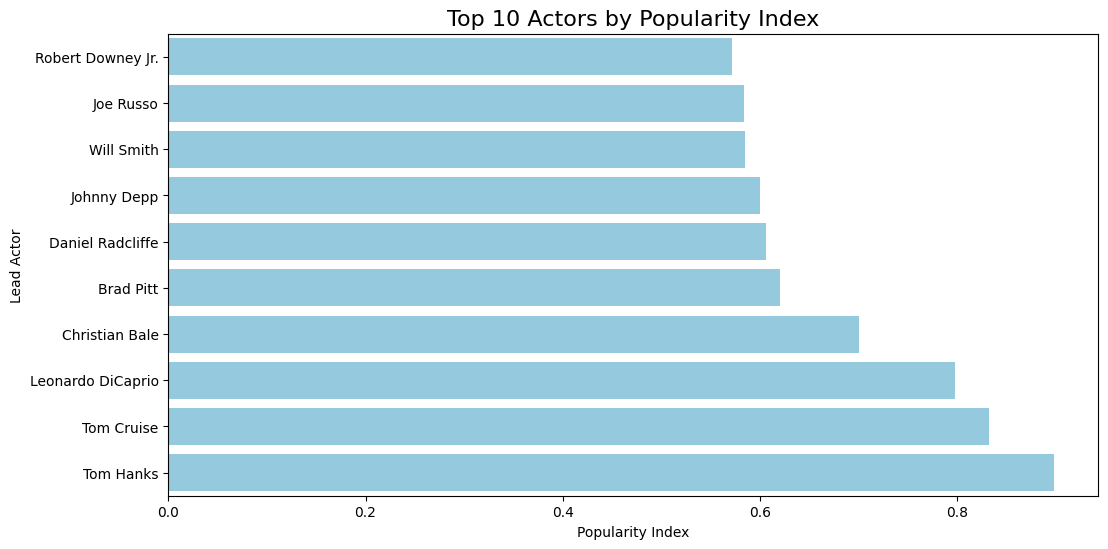

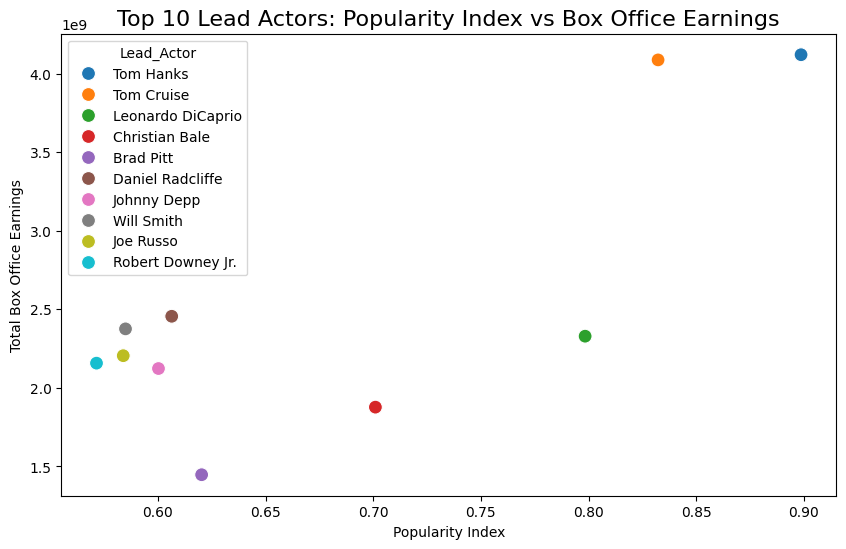

In [181]:
############################################# Hypothesis 2 ##########################################################

df['BoxOffice'] = pd.to_numeric(df['BoxOffice'].replace(r'[\$,]', '', regex=True), errors='coerce')
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'].replace(',', '', regex=True), errors='coerce')
df['Lead_Actor'] = df['Actor'].str.split(',').str[0].str.strip()

lead_actor_statistics_df = df.groupby('Lead_Actor').agg(
    num_movies=('Title', 'count'),
    avg_rating=('imdbRating', 'mean'),
    total_votes=('imdbVotes', 'sum'),
    total_box_office=('BoxOffice', 'sum')
).reset_index()

scaler = MinMaxScaler()
lead_actor_statistics_df.dropna(subset=['avg_rating', 'total_votes', 'total_box_office'], inplace=True)

lead_actor_statistics_df[['normalized_rating', 'normalized_votes', 'normalized_box_office']] = scaler.fit_transform(
    lead_actor_statistics_df[['avg_rating', 'total_votes', 'total_box_office']]
)

# Popularity index by averaging the normalized metrics
lead_actor_statistics_df['popularity_index'] = (lead_actor_statistics_df['normalized_rating'] + 
                                                lead_actor_statistics_df['normalized_votes'] + 
                                                lead_actor_statistics_df['normalized_box_office']) / 3

# Correlation analysis between popularity metrics and box office
correlation_matrix = lead_actor_statistics_df[['normalized_rating', 'normalized_votes', 'normalized_box_office']].corr()
print("Correlation Matrix between Actor Popularity and Box Office:")
print(correlation_matrix)

# Scatter plot for normalized popularity vs box office earnings
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Matrix between Actor Popularity Metrics and Box Office Earnings", fontsize=16)
plt.show()

most_famous_lead_actor_df = lead_actor_statistics_df.sort_values(by='popularity_index', ascending=False)
print(most_famous_lead_actor_df)

# Bar plot for Top 10 Actors by Popularity Index
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity_index', y='Lead_Actor', data=most_famous_lead_actor_df.head(10), color='skyblue')
plt.title("Top 10 Actors by Popularity Index", fontsize=16)
plt.xlabel("Popularity Index")
plt.ylabel("Lead Actor")
plt.gca().invert_yaxis()
plt.show()

# Scatter plot for Top 10 Lead Actors' Popularity vs Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity_index', y='total_box_office', data=most_famous_lead_actor_df.head(10), hue='Lead_Actor', s=100)
plt.title('Top 10 Lead Actors: Popularity Index vs Box Office Earnings', fontsize=16)
plt.xlabel('Popularity Index')
plt.ylabel('Total Box Office Earnings')
plt.show()


# Hypothesis 3: Runtime Performance
## '*Movies with a runtime between 120 and 150 minutes tend to perform better commercially'*


Average BoxOffice by Runtime Category:
Runtime_Category
120-150 min    7.686788e+07
150-180 min    9.603365e+07
180-210 min    1.285707e+08
90-120 min     4.106020e+07
< 90 min       3.472526e+07
> 210 min      3.288634e+07
Name: BoxOffice, dtype: float64


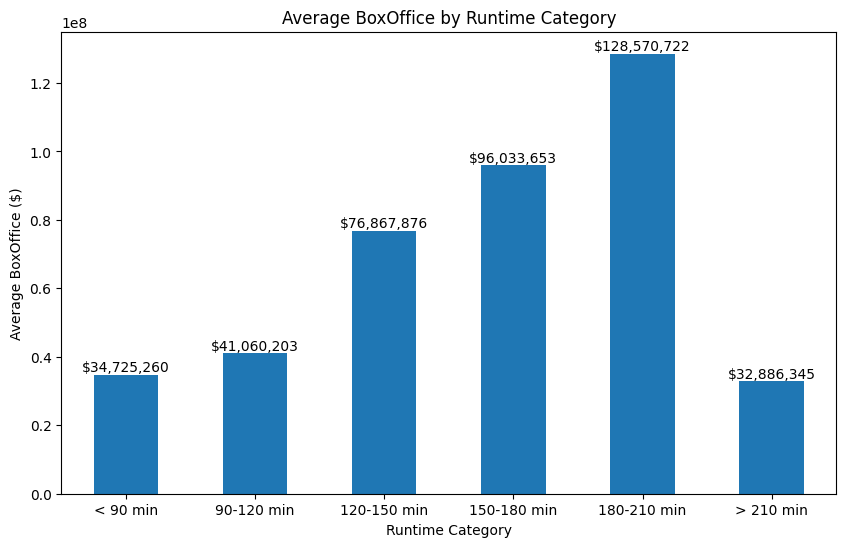

/var/folders/t2/40gs14tj4lg2536r26vzcyv40000gn/T/ipykernel_54714/1063390006.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=runtime_counts.index, y=runtime_counts.values, palette=[consistent_color])
/var/folders/t2/40gs14tj4lg2536r26vzcyv40000gn/T/ipykernel_54714/1063390006.py:64: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=runtime_counts.index, y=runtime_counts.values, palette=[consistent_color])


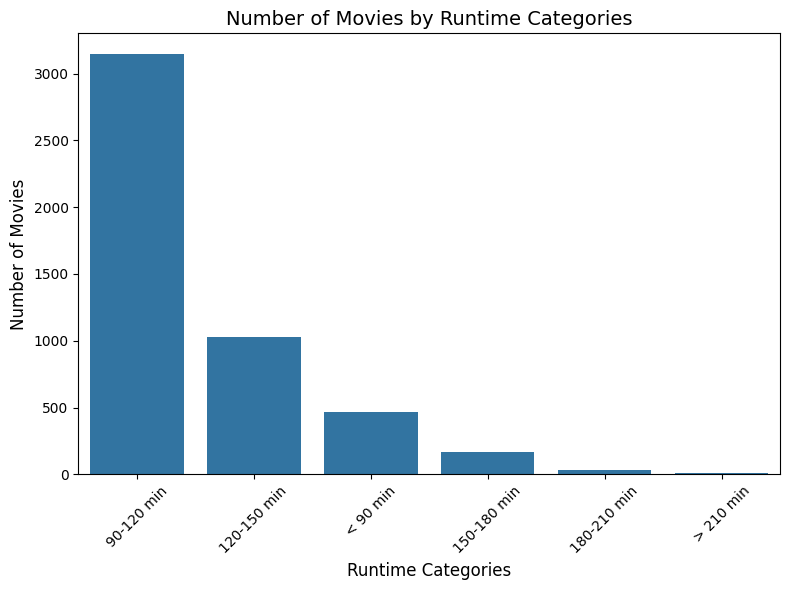

/var/folders/t2/40gs14tj4lg2536r26vzcyv40000gn/T/ipykernel_54714/1063390006.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_box_office = df.groupby('Runtime_category')['BoxOffice'].mean()


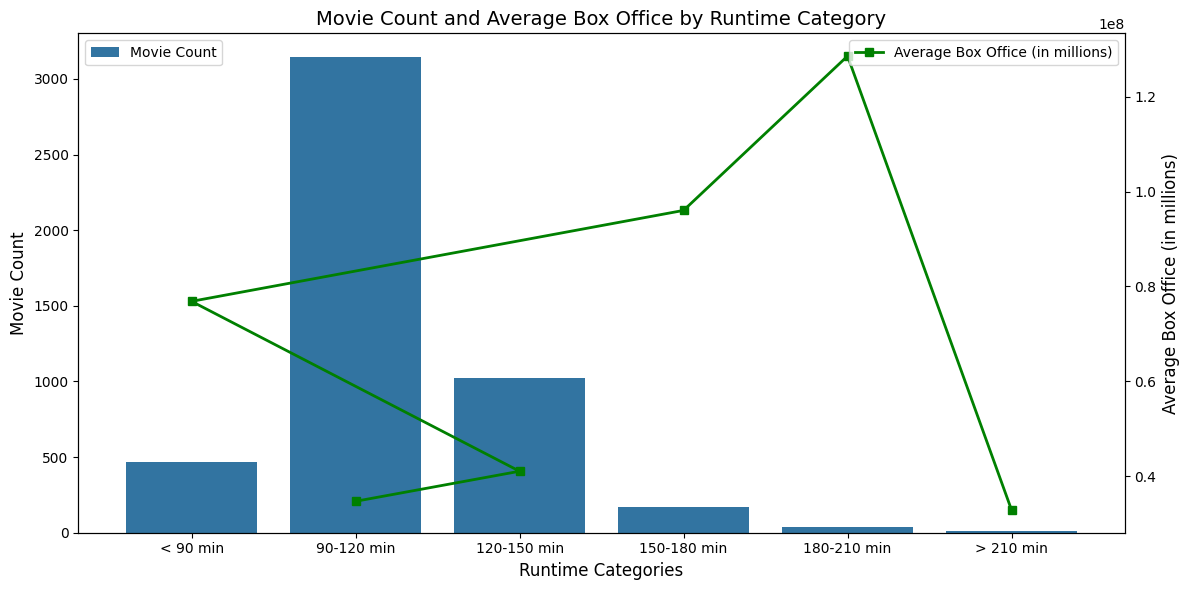

In [183]:
############################################# Hypothesis 3 ##########################################################

df['BoxOffice'] = df['BoxOffice'].replace({r'\$': '', r',': ''}, regex=True)
df['BoxOffice'] = pd.to_numeric(df['BoxOffice'], errors='coerce')

df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

def classify_runtime(runtime):
    if pd.isna(runtime):
        return 'Unknown'
    if runtime < 90:
        return '< 90 min'
    elif 90 <= runtime < 120:
        return '90-120 min'
    elif 120 <= runtime < 150:
        return '120-150 min'
    elif 150 <= runtime < 180:
        return '150-180 min'
    elif 180 <= runtime < 210:
        return '180-210 min'
    else:
        return '> 210 min'

df['Runtime_Category'] = df['Runtime'].apply(classify_runtime)
runtime_boxoffice_avg = df.groupby('Runtime_Category')['BoxOffice'].mean()
print("\nAverage BoxOffice by Runtime Category:")
print(runtime_boxoffice_avg)

categories = ['< 90 min','90-120 min','120-150 min', '150-180 min', '180-210 min', '> 210 min']
for category in categories:
    if category not in runtime_boxoffice_avg:
        runtime_boxoffice_avg[category] = None

# Order runtime categories
runtime_boxoffice_avg = runtime_boxoffice_avg.reindex(['< 90 min', '90-120 min', '120-150 min', 
                                                      '150-180 min', '180-210 min', '> 210 min'])

#-------------------------------- Visualization 1: Average Box office by Runtime Categories-------------------------------#
# Define a consistent color palette
consistent_color = "#1f77b4"  # You can choose any color, e.g., Seaborn's default color

# Graph
plt.figure(figsize=(10, 6))
runtime_boxoffice_avg.plot(kind='bar', color=consistent_color)
plt.title('Average BoxOffice by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average BoxOffice ($)')
plt.xticks(rotation=0)

# Adding text annotations for the bar values
for i in range(len(runtime_boxoffice_avg)):
    plt.text(i, runtime_boxoffice_avg.iloc[i], 
             f"${runtime_boxoffice_avg.iloc[i]:,.0f}" if pd.notna(runtime_boxoffice_avg.iloc[i]) else 'N/A', 
             ha='center', va='bottom')
plt.show()

#-------------------------------- Visualization 2: Number of Movies by Runtime Categories--------------------------------#

# Sort categories to display in the correct order
runtime_counts = df['Runtime_Category'].value_counts().sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=runtime_counts.index, y=runtime_counts.values, palette=[consistent_color])

# Add labels and title
plt.xlabel("Runtime Categories", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.title("Number of Movies by Runtime Categories", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

#-------------------------------- Visualization 3: Box office & Number of Movies by Runtime Categories-------------------------------#

# Categorize Runtime into bins
bins = [0, 90, 120, 150, 180, 210, float('inf')]
labels = ['< 90 min', '90-120 min', '120-150 min', '150-180 min', '180-210 min', '> 210 min']
df['Runtime_category'] = pd.cut(df['Runtime'], bins=bins, labels=labels, right=False)

# Calculate movie count per category
runtime_counts = df['Runtime_category'].value_counts()

# Calculate the average box office per category
df['BoxOffice'] = df['BoxOffice'].fillna(df['BoxOffice'].median())  # Handle missing BoxOffice values by replacing with median
average_box_office = df.groupby('Runtime_category')['BoxOffice'].mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar chart for the movie count with consistent color
sns.barplot(x=runtime_counts.index, y=runtime_counts.values, ax=ax1, color=consistent_color, label="Movie Count")

# Create a second y-axis for the average box office
ax2 = ax1.twinx()
ax2.plot(runtime_counts.index, average_box_office, color="green", marker='s', label="Average Box Office (in millions)", linewidth=2)

# Add labels and title
ax1.set_xlabel("Runtime Categories", fontsize=12)
ax1.set_ylabel("Movie Count", fontsize=12)
ax2.set_ylabel("Average Box Office (in millions)", fontsize=12)
plt.title("Movie Count and Average Box Office by Runtime Category", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()
